# Apple stock 'Close' value prediction

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM

C:\Users\Omar\Anaconda3\envs\mostRecent\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  after removing the cwd from sys.path.


ModuleNotFoundError: No module named 'keras'

## Stock data function configured to drop all columns except 'Open','High' and 'Close'

In [2]:
def get_stock_data(stock_name, normalized=0):
    
    col_names = ['Date','Open','High','Low','Close','Volume']
    stocks = pd.read_csv("apple.csv", header=0, names=col_names) 
    df = pd.DataFrame(stocks)
    df.drop(df.columns[[0,3,5]], axis=1, inplace=True) 
    return df

## Loading Apple stock data for the last 3 years

In [3]:
stock_name = 'apple'
df = get_stock_data(stock_name,0)
df.tail()

,Open,High,Close
1090,111.11,111.11,103.74
1091,94.87,108.80,103.12
1092,110.43,111.90,105.76
1093,114.08,114.35,112.65
1094,116.10,116.52,115.01


In [4]:
df['High'] = df['High'] / 1000
df['Open'] = df['Open'] / 1000
df['Close'] = df['Close'] / 1000
df.head(5)

,Open,High,Close
0,0.28053,0.28425,0.28400
1,0.28223,0.28265,0.27944
2,0.27950,0.28118,0.28002
3,0.27980,0.28190,0.27974
4,0.27957,0.28177,0.28041


## Reshape data & dividing it into data set and testing set 
## configure to accept 3 features.
## Returns training data set, training labels, testing data set, testing labels

In [5]:
def load_data(stock, seq_len):
    amount_of_features = len(stock.columns)
    data = stock.values#pd.DataFrame(stock)
    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    
    result = np.array(result)
    row = round(0.9 * result.shape[0])
    train = result[:int(row), :]
    x_train = train[:, :-1]
    y_train = train[:, -1][:,-1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1][:,-1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  

    return [x_train, y_train, x_test, y_test]


## Building model functions

In [6]:
def build_model(layers):
        d = 0.2
        model = Sequential()
        #units: Positive integer, dimensionality of the output space.
        #return_sequences: Boolean. Whether to return the last output in the output sequence, or the full sequence.
        # input_shape = input_dim & input_length
        #return_sequences=True means this layer output is always fed into the next layer
        model.add(LSTM(128, input_shape=(layers[1], layers[0]), return_sequences=True))
        model.add(Dropout(d))
        model.add(LSTM(64, input_shape=(layers[1], layers[0]), return_sequences=False))
        #return_sequences=False since output is going to be fed to the next layer at the end of the sequence as a prediction vector
        model.add(Dropout(d))
        model.add(Dense(16,kernel_initializer='uniform',activation='relu'))    #to aggregate the data    
        model.add(Dense(1,kernel_initializer='uniform',activation='relu'))
        model.compile(loss='mse',optimizer='adam',metrics=['accuracy']) #mean squared error loss function & optimizer adam
        return model

In [7]:
def build_modelrmsprop(layers):
        d = 0.2
        model = Sequential()
        model.add(LSTM(128, input_shape=(layers[1], layers[0]), return_sequences=True))
        model.add(Dropout(d))
        model.add(LSTM(64, input_shape=(layers[1], layers[0]), return_sequences=False))
        model.add(Dropout(d))
        model.add(Dense(16,kernel_initializer='uniform',activation='relu'))   
        model.add(Dense(1,kernel_initializer='uniform',activation='relu'))
        model.compile(loss='mse',optimizer='rmsprop',metrics=['accuracy'])
        return model

## Setting X and Y for training and testing

In [8]:
window = 5
X_train, y_train, X_test, y_test = load_data(df[::-1], window)# all items in the array, reversed
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (980, 5, 3)
y_train (980,)
X_test (109, 5, 3)
y_test (109,)


## Loading the model sequence structure

In [9]:
model = build_model([3,window,1])
modelrmsprop = build_modelrmsprop([3,window,1])

## Executing the model & RMS/RMSE results
## root mean square error

In [10]:
model.fit(
    X_train,
    y_train,
    batch_size=512,
    epochs=500,
    validation_split=0.1,
    verbose=0)
modelrmsprop.fit(
    X_train,
    y_train,
    batch_size=512,
    epochs=500,
    validation_split=0.1,
    verbose=0)

In [11]:
trainScore = model.evaluate(X_train, y_train, verbose=0)
print('Train Score: MSE = ' , trainScore[0], ' RMSE = ' ,  math.sqrt(trainScore[0]))

testScore = model.evaluate(X_test, y_test, verbose=0)
print('Test Score: MSE = ' , testScore[0], ' RMSE = ' ,  math.sqrt(testScore[0]))

Train Score: MSE =  1.9863637417260253e-05  RMSE =  0.004456864078840665
Test Score: MSE =  4.197844093742379e-05  RMSE =  0.006479077167114449


# TEST THE MODEL

In [12]:
p = model.predict(X_test)*1000
y_test *= 1000
pRmsprop = modelrmsprop.predict(X_test)*1000

## Predictions vs Real results

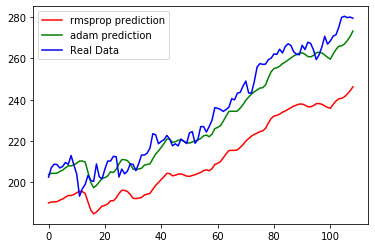

In [13]:
import matplotlib.pyplot as plt2

plt2.plot(pRmsprop,color='red', label='rmsprop prediction')
plt2.plot(p,color='green', label='adam prediction')
plt2.plot(y_test,color='blue', label='Real Data')
plt2.legend(loc='upper left')
plt2.show()